## Run Spark queries on an S3-based Ceph external cluster 

In [19]:
### Test your Spark cluster connectivity 

In [111]:
from pyspark.sql import SparkSession, SQLContext
import os
import socket

# create a spark session
spark_cluster_url = f"spark://{os.environ['SPARK_CLUSTER']}:7077"
spark = SparkSession.builder.master(spark_cluster_url).getOrCreate()

# test your spark connection
spark.range(5, numPartitions=5).rdd.map(lambda x: socket.gethostname()).distinct().collect()

['spark-cluster-kube-admin-w-wb54g', 'spark-cluster-kube-admin-w-x5zn9']

In [18]:
#### Run a Spark query and pull the uploaded CSV to exclude the data

In [112]:
# Create a configuration for a S3 connection towards Ceph RGW
s3_region = 'us-east-1' # fill in for AWS, blank for Ceph
s3_endpoint_url = 'http://10.32.0.3:8080'
s3_access_key_id = '2KESHB41KITLKHU44BNS'
s3_secret_access_key = 'DgArbbUCYfIxnZB9UFx3jop5mpvDxlrudQ7SJcXM'
s3_bucket = 'spark-bucket-1143d1c8-e321-496a-821c-9c1b89297685'

# for easy download
!pip install wget

import wget
import boto3

# configure boto S3 connection
s3 = boto3.client('s3',
                  s3_region,
                  endpoint_url = s3_endpoint_url,
                  aws_access_key_id = s3_access_key_id,
                  aws_secret_access_key = s3_secret_access_key)

# download the sample data file
url = "https://people.sc.fsu.edu/~jburkardt/data/csv/grades.csv"
file = wget.download(url=url, out='sample_data.csv')

#upload the file to storage
s3.upload_file(file, s3_bucket, "sample_data.csv")

You should consider upgrading via the 'pip install --upgrade pip' command.


In [113]:
#### Create you Spark s3a based configuration and run the query 

In [114]:
# Use the above S3 values in order ro run query with Spark using the s3a connector 
hadoopConf = spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.endpoint", s3_endpoint_url)
hadoopConf.set("fs.s3a.access.key", s3_access_key_id)
hadoopConf.set("fs.s3a.secret.key", s3_secret_access_key)
hadoopConf.set("fs.s3a.path.style.access", "true")
hadoopConf.set("fs.s3a.connection.ssl.enabled", "true") # false if not https

# Print CSV values coming from the S3 bucket 
data = spark.read.csv('s3a://' + s3_bucket + '/sample_data.csv',sep=",", header=True)
df = data.toPandas()
df.head()


,Last name,"""First name""","""SSN""","""Test1""","""Test2""","""Test3""","""Test4""","""Final""","""Grade"""
0,Alfalfa,"""Aloysius""","""123-45-6789""",40.0,90.0,100.0,83.0,49.0,"""D-"""
1,Alfred,"""University""","""123-12-1234""",41.0,97.0,96.0,97.0,48.0,"""D+"""
2,Gerty,"""Gramma""","""567-89-0123""",41.0,80.0,60.0,40.0,44.0,"""C"""
3,Android,"""Electric""","""087-65-4321""",42.0,23.0,36.0,45.0,47.0,"""B-"""
4,Bumpkin,"""Fred""","""456-78-9012""",43.0,78.0,88.0,77.0,45.0,"""A-"""


In [115]:
# Print final grades for students, notice there is flase data here on row 8

In [120]:
df[' "Final"']

0         49.0
1         48.0
2         44.0
3         47.0
4         45.0
5         46.0
6         43.0
7         50.0
8          "A"
9         97.0
10        40.0
11        45.0
12        77.0
13        90.0
14         4.0
15        40.0
Name:  "Final", dtype: object

In [117]:
# Print final grades in a plot 

In [125]:
import pandas as pd 
list_final_grades = list(df[' "Final"'][0:7]) + list(df[' "Final"'][9:15])
print(list_final_grades)

['    49.0', '    48.0', '    44.0', '    47.0', '    45.0', '    46.0', '    43.0', '    97.0', '    40.0', '    45.0', '    77.0', '    90.0', '     4.0']


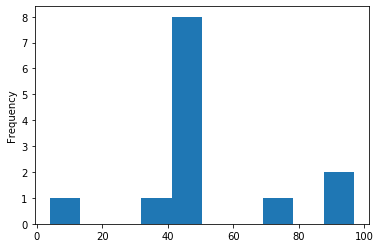

In [126]:
pd.Series(list_final_grades).astype(float).astype(int).plot.hist()